In [1]:
#Stuff to read files
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [2]:
#Map Background 
def create_map_background():
    #dataproj = ccrs.PlateCarree(central_longitude=-160)
    dataproj = ccrs.PlateCarree()
    fig= plt.figure(figsize=(48, 15))
    ax = plt.subplot(111, projection=dataproj)
    ax.set_extent([-84, -94, 13, 23],ccrs.PlateCarree())
    #ax.set_extent([-60, -100, 0, 23],ccrs.PlateCarree())
    #ax.set_extent([180, -180, -82, 82],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    #ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True) 
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([-100,-95,-90,-85,-80])
    gl.ylocator = mticker.FixedLocator([0,5,10,15,20,25,30])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    #ax.stock_img()
    return fig, ax

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def wind():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/160, "#000000"), 
    (34/160, "#a6a6a6"),
    (34/160, "#4245a6"),
    (64/160, "#29a668"),
    (96/160, "#cccc33"),
    (113/160, "#cc3333"),
    (137/160, "#cc7acc"),
    (160/160, "#ffffff")])

    return newcmp

In [4]:
#Max lists for all our extreme files
Dean_unadjusted_d01 = sorted(glob.glob('/Users/cjmasiel/Desktop/unadjusted/wrfxtrm_d01*'))
Dean_adjusted_d01 = sorted(glob.glob('//Users/cjmasiel/Desktop/adjusted/wrfxtrm_d01*'))

#We need to adjust the one set since my other run ended earlier
Dean_unadjusted_d01_n = Dean_unadjusted_d01[:-3]


Parent_wrfout_unadjusted_d01 = sorted(glob.glob('/Users/cjmasiel/Desktop/unadjusted/wrfout_d01*'))
Parent_wrfout_adjusted_d01 = sorted(glob.glob('//Users/cjmasiel/Desktop/adjusted/wrfout_d01*'))

#We need to adjust the one set since my other run ended 9 hours earlier
Parent_wrfout_unadjusted_d01_n = Parent_wrfout_unadjusted_d01[:-9]

In [5]:
wrf_out_data = xr.open_dataset(Dean_unadjusted_d01[0]) 
wrf_out_data

<xarray.Dataset>
Dimensions:       (Time: 1, south_north: 437, west_east: 795)
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/37)
    Times         (Time) |S19 ...
    T2MIN         (Time, south_north, west_east) float32 ...
    T2MAX         (Time, south_north, west_east) float32 ...
    TT2MIN        (Time, south_north, west_east) float32 ...
    TT2MAX        (Time, south_north, west_east) float32 ...
    T2MEAN        (Time, south_north, west_east) float32 ...
    ...            ...
    TRAINCVMAX    (Time, south_north, west_east) float32 ...
    TRAINNCVMAX   (Time, south_north, west_east) float32 ...
    RAINCVMEAN    (Time, south_north, west_east) float32 ...
    RAINNCVMEAN   (Time, south_north, west_east) float32 ...
    RAINCVSTD     (Time, south_north, west_east) float32 ...
    RAINNCVSTD    (Time, south_north, west_east) float32 ...
Attributes: (12/86)
    TITLE:                            OUTPUT FROM WRF V4.4.2 MODEL
    START_DATE:                      2007-08-21_00:00:00
    WEST-EAST_GRID_DIMENSION:        796
    SOUTH-NORTH_GRID_DIMENSION:      438
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              12000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [6]:
#What is the trehshold we want too analyze on:
Threshold = 18 #units in m/s

In [7]:
#We are creating a list that contains the whole array of maximum values of wind speeds:
doCount = True
numfiles=len(Dean_unadjusted_d01_n)  #Length of the files, doesn't matter which one I use, they are the same length

e_we = 795   #e_ew of our parent domain, number of grid spaces in the horizontal
e_sn = 437   #e_sn of our parent domain, number of grid spaces in the vertical

windspeed3d_land = np.zeros((numfiles, e_sn, e_we)) # empty array with [times, x grid, ygrid] needed for appending the count array

Big_List = []

for i in range(0,numfiles):
    #below is to plot time so we make sure our loop is iterating through files correctly
    ncfile = Dataset(Dean_unadjusted_d01_n[i])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)
    
    #landmask = getvar(ncfile, 'LANDMASK')
    
    wrf_out_data = xr.open_dataset(Dean_unadjusted_d01_n[i]) 
    Max_10m_winds = wrf_out_data['SPDUV10MAX'][0,:,:]
    Max_10m_winds_land = wrf_out_data['SPDUV10MAX'][0,:,:] #* landmask
    Big_List.append(Max_10m_winds)
    
    #count portion 
    wspdgreater = np.where(Max_10m_winds_land >= Threshold, Max_10m_winds_land, 0) # wind speed greater than threshold of TS storm force winds
    wspdcount = np.where(wspdgreater == 0, wspdgreater, 1)   # where the array is 0 is kept and where it is greater than 0 is turned to 1 for counting purposes     
    windspeed3d_land[i,:,:] = wspdcount                               # append the wspdcount to the empty array
    
    if doCount == True:
        counttotal = windspeed3d_land.sum(axis=0) # sum along ensemble members
        count_adjust = np.where(counttotal >=1 , counttotal, 0 )      #figure out in the array where values are greater than or equal to 1
        count_final = np.where(count_adjust == 0 , count_adjust, 1)   #want our arrays to be binary, 0 or 1's

WRF valid time:  2007-08-21_00
WRF valid time:  2007-08-21_03
WRF valid time:  2007-08-21_06
WRF valid time:  2007-08-21_09
WRF valid time:  2007-08-21_12
WRF valid time:  2007-08-21_15
WRF valid time:  2007-08-21_18
WRF valid time:  2007-08-21_21
WRF valid time:  2007-08-22_00
WRF valid time:  2007-08-22_03


/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.0, 1.0, 'Location of Tropical Storm Force Winds, Control run')

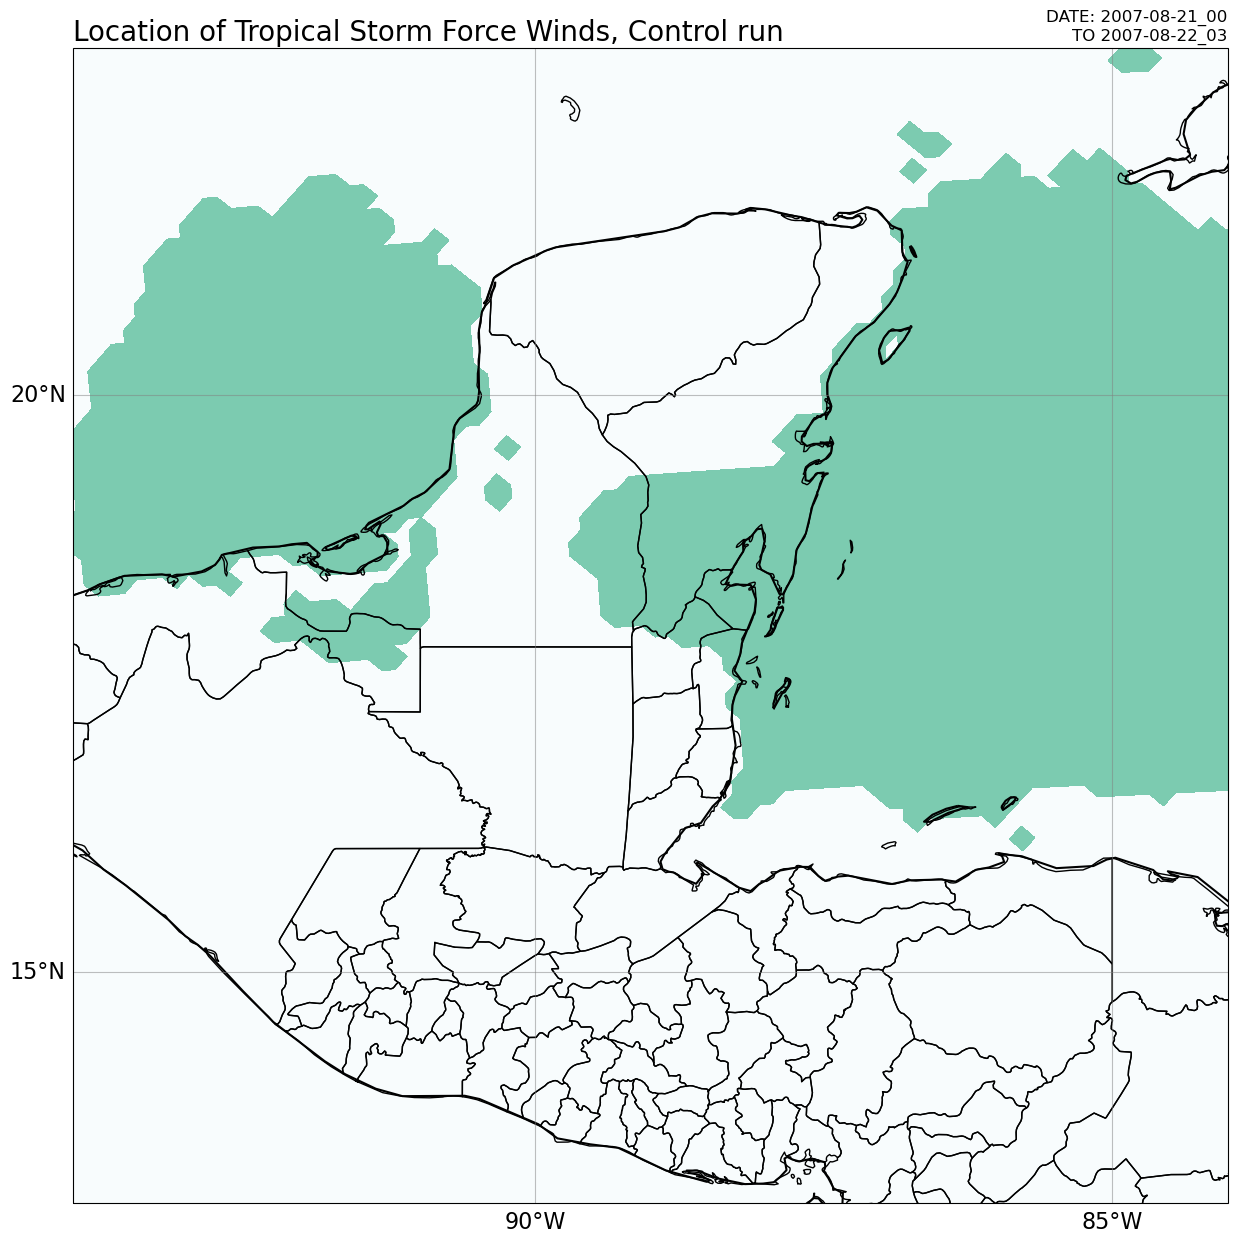

In [8]:
#We will look at the first WRF out file for plotting information
wrf_out_first_file = xr.open_dataset(Parent_wrfout_unadjusted_d01_n[0])  
lon = wrf_out_first_file['XLONG'][0,:,:].values                    #Array of longitudes
lat = wrf_out_first_file['XLAT'][0,:,:].values                     #Array of Latitudes

count_control = count_final
#count_final[count_final==0] = np.nan                         #replace 0 elements with nan's so they do no plot

fig, ax = create_map_background()

plot = plt.contourf(lon, lat, count_final, origin = 'lower', levels = np.arange(0,2,1),
            cmap = 'BuGn', alpha = .85, extend ='both')

#cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
#cbar.ax.set_xlabel('Difference', fontsize = 20)


plt.title(f'DATE: 2007-08-21_00\nTO 2007-08-22_03', loc = 'right', fontsize = 12)
plt.title('Location of Tropical Storm Force Winds, Control run', loc = 'left', fontsize = 20)

In [9]:
#We are creating a list that contains the whole array of maximum values of wind speeds:
doCount = True
numfiles=len(Dean_adjusted_d01)  #Length of the files, doesn't matter which one I use, they are the same length

e_we = 795   #e_ew of our parent domain, number of grid spaces in the horizontal
e_sn = 437   #e_sn of our parent domain, number of grid spaces in the vertical

windspeed3d_land_a = np.zeros((numfiles, e_sn, e_we)) # empty array with [times, x grid, ygrid] needed for appending the count array

Big_List_a = []

for i in range(0,numfiles):
    #below is to plot time so we make sure our loop is iterating through files correctly
    ncfile = Dataset(Dean_adjusted_d01[i])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)
    
    #landmask = getvar(ncfile, 'LANDMASK')
    
    wrf_out_data_a = xr.open_dataset(Dean_adjusted_d01[i]) 
    Max_10m_winds_a = wrf_out_data_a['SPDUV10MAX'][0,:,:]
    Max_10m_winds_land_a = wrf_out_data_a['SPDUV10MAX'][0,:,:] #* landmask
    Big_List_a.append(Max_10m_winds_a)
    
    #count portion 
    wspdgreater = np.where(Max_10m_winds_land_a >= Threshold, Max_10m_winds_land_a, 0) # wind speed greater than threshold of TS storm force winds
    wspdcount = np.where(wspdgreater == 0, wspdgreater, 1)                 # where the array is 0 is kept and where it is greater than 0 is turned to 1 for counting purposes     
    windspeed3d_land_a[i,:,:] = wspdcount                                         # append the wspdcount to the empty array
    
    if doCount == True:
        counttotal = windspeed3d_land_a.sum(axis=0) # sum along ensemble members
        count_adjust = np.where(counttotal >=1 , counttotal, 0 )      #figure out in the array where values are greater than or equal to 1
        count_final_a = np.where(count_adjust == 0 , count_adjust, 1)   #want our arrays to be binary, 0 or 1's

WRF valid time:  2007-08-20_12
WRF valid time:  2007-08-20_15
WRF valid time:  2007-08-20_18
WRF valid time:  2007-08-20_21
WRF valid time:  2007-08-21_00
WRF valid time:  2007-08-21_03
WRF valid time:  2007-08-21_06
WRF valid time:  2007-08-21_09
WRF valid time:  2007-08-21_12
WRF valid time:  2007-08-21_15


Text(0.0, 1.0, 'Location of Tropical Storm Force Winds, Research run')

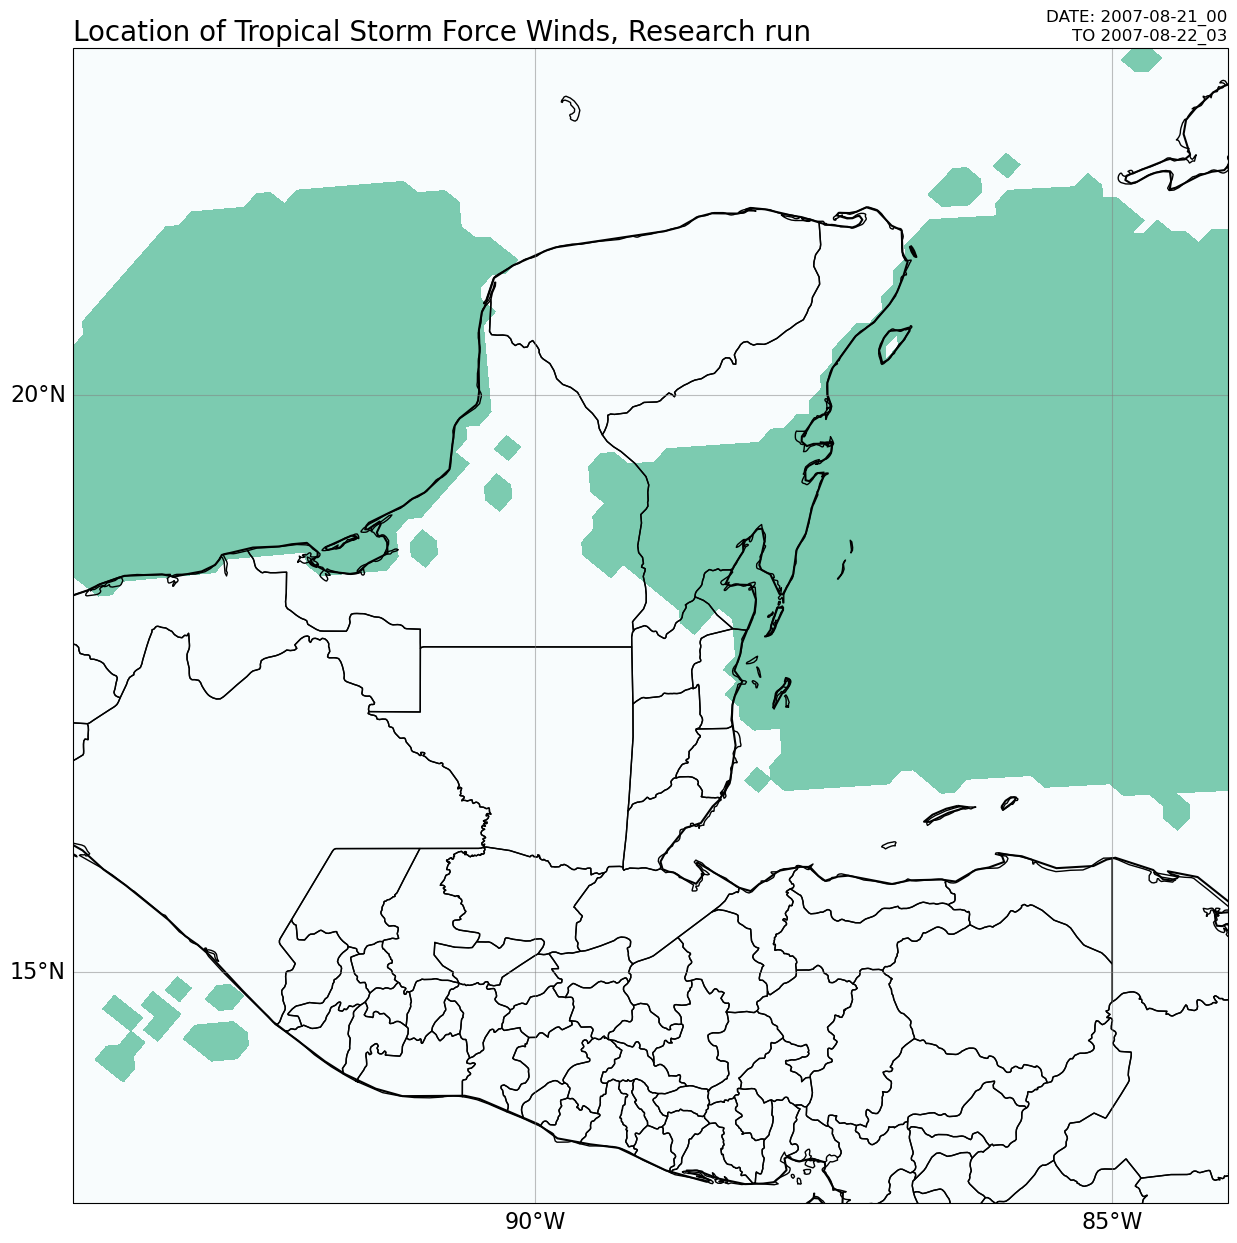

In [10]:
count_expirement = count_final_a
#print(count_expirement)
#count_final_a[count_final_a==0] = np.nan          #replace 0 elements with nan's so they do no plot

fig, ax = create_map_background()

plot = plt.contourf(lon, lat, count_final_a, origin = 'lower', levels = np.arange(0,2,1),
            cmap = 'BuGn', alpha = .85, extend ='both')
#cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
#cbar.ax.set_xlabel('number', fontsize = 20)


plt.title(f'DATE: 2007-08-21_00\nTO 2007-08-22_03', loc = 'right', fontsize = 12)
plt.title('Location of Tropical Storm Force Winds, Research run', loc = 'left', fontsize = 20)

Text(0.0, 1.0, 'Difference between day vs. nightime landfall')

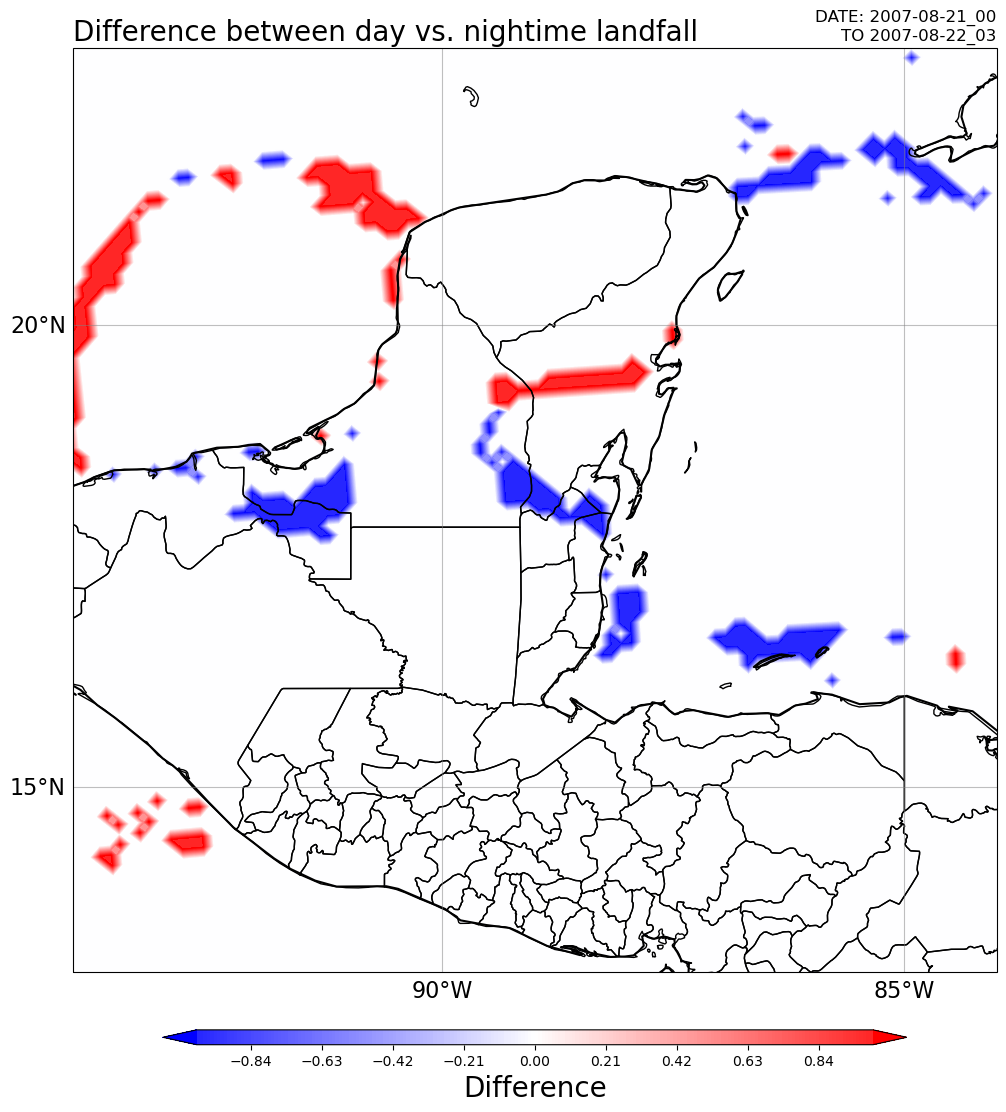

In [11]:
#now plot the differenct between the two
difference = count_expirement - count_control

#difference[difference==0] = np.nan

fig, ax = create_map_background()

plot = plt.contourf(lon, lat, difference, origin = 'lower', levels = np.arange(-1,1.01,.01),
            cmap = 'bwr', alpha = .85, extend ='both')

cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
cbar.ax.set_xlabel('Difference', fontsize = 20)


plt.title(f'DATE: 2007-08-21_00\nTO 2007-08-22_03', loc = 'right', fontsize = 12)
plt.title('Difference between day vs. nightime landfall', loc = 'left', fontsize = 20)

In [12]:
max_winds1 = xr.ufuncs.maximum(Big_List[0],Big_List[1])
max_winds2 = xr.ufuncs.maximum(Big_List[2],Big_List[3])
max_winds3 = xr.ufuncs.maximum(Big_List[4],Big_List[5])
max_winds4 = xr.ufuncs.maximum(Big_List[6],Big_List[7])
max_winds5 = xr.ufuncs.maximum(Big_List[8],Big_List[9])
#max_winds6 = xr.ufuncs.maximum(Big_List[10],Big_List[11])

#now that we have the maximum of all these, we now need to compare them
max_winds1_1 = xr.ufuncs.maximum(max_winds1,max_winds2)
max_winds2_1 = xr.ufuncs.maximum(max_winds3,max_winds4)
max_winds3_1 = xr.ufuncs.maximum(max_winds5,max_winds1)

#Now we need to reduce it again!
max_winds1_2 = xr.ufuncs.maximum(max_winds1_1,max_winds2_1)
max_winds2_2 = xr.ufuncs.maximum(max_winds2_1,max_winds3_1)

#Now we need to reduce it again!
max_winds1_3 = xr.ufuncs.maximum(max_winds1_2,max_winds2_2)

/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/138092813.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds1 = xr.ufuncs.maximum(Big_List[0],Big_List[1])
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:3081: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/xarray/core/variable.py:2409: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/138092813.py:2: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds2 = xr.ufuncs.maximum(Big_List[2],Big_List[3])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/138092813.py:3: FutureWarning: xarray.ufuncs is dep

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.0, 1.0, 'Control Dean Run')

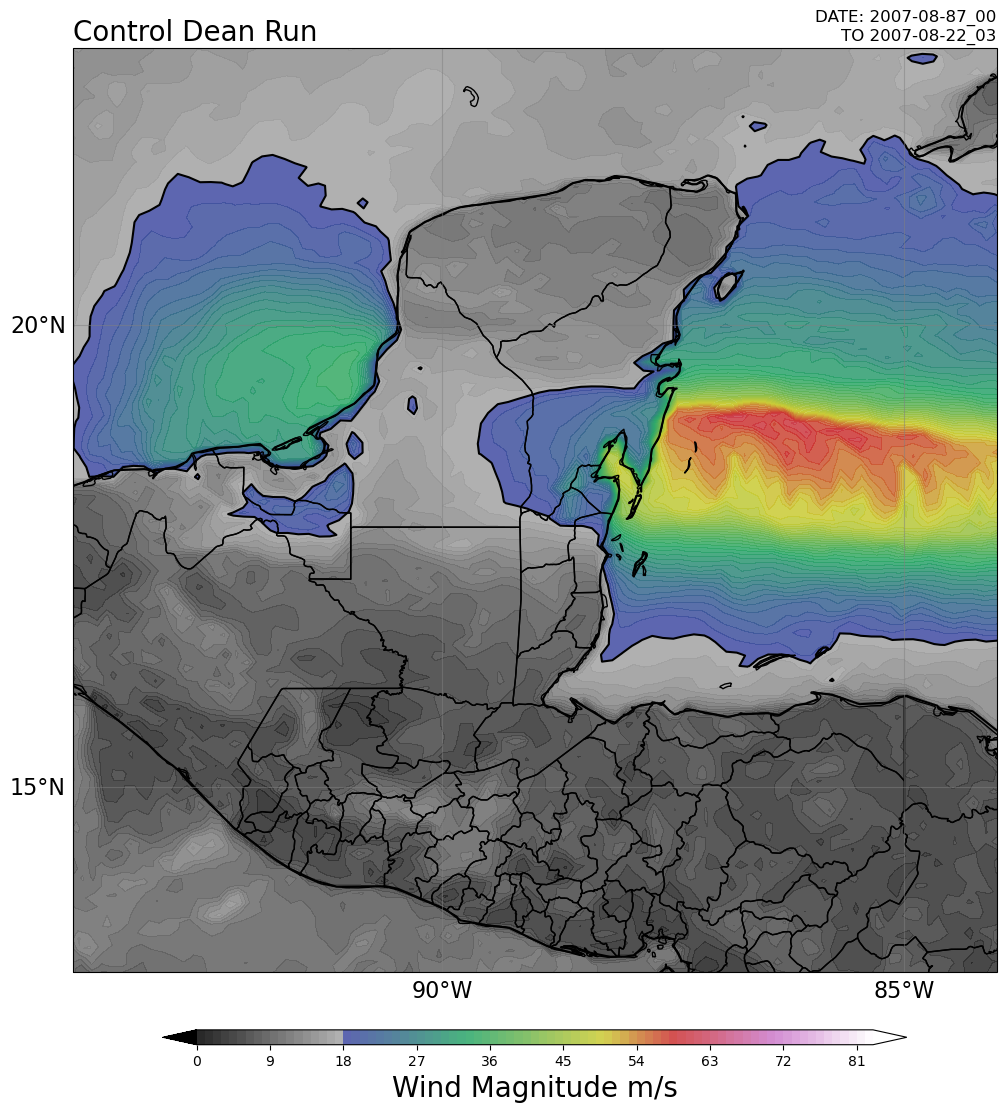

In [13]:
fig, ax = create_map_background()

plot = plt.contourf(lon,lat, max_winds1_3, origin = 'lower', levels = np.arange(0,84,1),
                    cmap = wind(), alpha = .85, extend ='both')

cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
cbar.ax.set_xlabel('Wind Magnitude m/s', fontsize = 20)

contourdifSSTglobeAnomaly = plt.contour(lon, lat, max_winds1_3, np.arange(0,36,18), 
                                        linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())

plt.title(f'DATE: 2007-08-87_00\nTO 2007-08-22_03', loc = 'right', fontsize = 12)
plt.title('Control Dean Run', loc = 'left', fontsize = 20)

In [14]:
max_winds1_a = xr.ufuncs.maximum(Big_List_a[0],Big_List_a[1])
max_winds2_a = xr.ufuncs.maximum(Big_List_a[2],Big_List_a[3])
max_winds3_a = xr.ufuncs.maximum(Big_List_a[4],Big_List_a[5])
max_winds4_a = xr.ufuncs.maximum(Big_List_a[6],Big_List_a[7])
max_winds5_a = xr.ufuncs.maximum(Big_List_a[8],Big_List_a[9])
#max_winds6_a = xr.ufuncs.maximum(Big_List_a[10],Big_List_a[11])

#now that we have the maximum of all these, we now need to compare them
max_winds1_1_a = xr.ufuncs.maximum(max_winds1_a,max_winds2_a)
max_winds2_1_a = xr.ufuncs.maximum(max_winds3_a,max_winds4_a)
max_winds3_1_a = xr.ufuncs.maximum(max_winds5_a,max_winds1_a)

#Now we need to reduce it again!
max_winds1_2_a = xr.ufuncs.maximum(max_winds1_1_a,max_winds2_1_a)
max_winds2_2_a = xr.ufuncs.maximum(max_winds2_1_a,max_winds3_1_a)

#Now we need to reduce it again!
max_winds1_3_a = xr.ufuncs.maximum(max_winds1_2_a,max_winds2_2_a)

/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/1872000822.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds1_a = xr.ufuncs.maximum(Big_List_a[0],Big_List_a[1])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/1872000822.py:2: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds2_a = xr.ufuncs.maximum(Big_List_a[2],Big_List_a[3])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/1872000822.py:3: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds3_a = xr.ufuncs.maximum(Big_List_a[4],Big_List_a[5])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/1872000822.py:4: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  max_winds4_a = xr.ufuncs.maximum(Big_List_a[6],Big_List_a[7])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_33614/1872000822.py:5: FutureWarning:

Text(0.0, 1.0, 'Adjusted Dean Run')

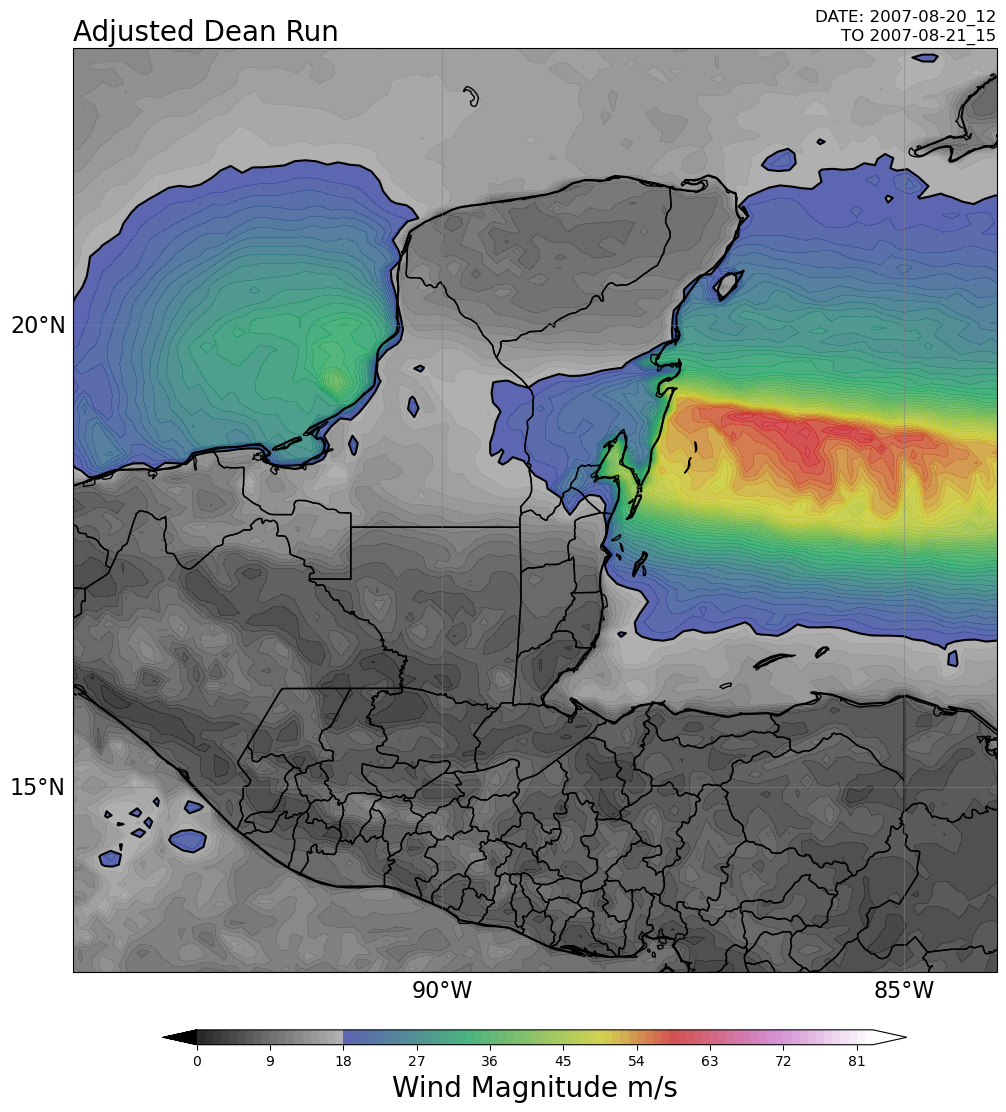

In [15]:
fig, ax = create_map_background()

plot = plt.contourf(lon,lat, max_winds1_3_a, origin = 'lower', levels = np.arange(0,84,1),
                    cmap = wind(), alpha = .85, extend ='both')

cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
cbar.ax.set_xlabel('Wind Magnitude m/s', fontsize = 20)

contourdifSSTglobeAnomaly = plt.contour(lon, lat, max_winds1_3_a, np.arange(0,36,18), 
                                        linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())

plt.title(f'DATE: 2007-08-20_12\nTO 2007-08-21_15', loc = 'right', fontsize = 12)
plt.title('Adjusted Dean Run', loc = 'left', fontsize = 20)

In [16]:
#For our first case, we just care for the first time step to make sure it is working correctly

#first, we are going to calculate the pressure center using the parent domain
lat_pmin = []                                                #Empty List for Latitude Data
lon_pmin = []                                                #Empty List for longitude Data

#create list for WRF_OUT_data
WRF_OUT_DATA = []   

#create empty list for pressure pertubation
pressure_minimum_Dean_Adjust = []

for i in range(0,len(Parent_wrfout_adjusted_d01)): #For full Dataset
    wrf_out_data = xr.open_dataset(Parent_wrfout_adjusted_d01[i])  #Open WRF_Out Data (I glob glob my whole directory)
    WRF_OUT_DATA.append(wrf_out_data)

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Now, to find the location of the lowest surface pressure pertubation
    minpressure = np.min(surface_P_pertubation[:,:])
    minp = minpressure.values
    pressure_minimum_Dean_Adjust.append((minp + 99714.99) / 100)

    #Now we know what the lowest pressure is, we have to find the index value for where it occurs
    da = surface_P_pertubation
    p_index = np.argwhere(da.where(da == minp,0).values)
    s_n = p_index[0][0]
    w_e = p_index[0][1]
    lat_pmin.append(s_n)
    lon_pmin.append(w_e)
    
lat_Dean_Adjusted = []
lon_Dean_Adjusted = []

for i in range(len(lat_pmin)):
    lon = WRF_OUT_DATA[i]['XLONG'][0,lat_pmin[i],lon_pmin[i]].values
    lon_Dean_Adjusted.append(lon)
    lat = WRF_OUT_DATA[i]['XLAT'][0,lat_pmin[i],lon_pmin[i]].values
    lat_Dean_Adjusted.append(lat)

In [17]:
import pandas as pd
#For our first case, we just care for the first time step to make sure it is working correctly

#first, we are going to calculate the pressure center using the parent domain
lat_pmin = []                                                #Empty List for Latitude Data
lon_pmin = []                                                #Empty List for longitude Data

#create list for WRF_OUT_data
WRF_OUT_DATA = []   
 
#create empty list for pressure pertubation
pressure_minimum_Dean_MYNN = [] 

#Create empty list for date
date_Dean_MYNN = []

for i in range(len(Parent_wrfout_unadjusted_d01_n)): #For full Dataset
    wrf_out_data = xr.open_dataset(Parent_wrfout_unadjusted_d01_n[i])  #Open WRF_Out Data (I glob glob my whole directory)
    WRF_OUT_DATA.append(wrf_out_data)
    
    #First, lets find the data data assocaited with all of them
    time = wrf_out_data['XTIME'][0].values
    time_changed = time.astype(np.datetime64)
    ts = pd.to_datetime(str(time_changed))
    d = ts.strftime('%Y-%m-%d %H:%M')
    date_Dean_MYNN.append(d)

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    Base = wrf_out_data['PB']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Now, to find the location of the lowest surface pressure pertubation
    minpressure = np.min(surface_P_pertubation[:,:])
    minp = minpressure.values
    pressure_minimum_Dean_MYNN.append((minp + 99714.99) / 100)

    #Now we know what the lowest pressure is, we have to find the index value for where it occurs
    da = surface_P_pertubation
    p_index = np.argwhere(da.where(da == minp,0).values)
    s_n = p_index[0][0]
    w_e = p_index[0][1]
    lat_pmin.append(s_n)
    lon_pmin.append(w_e)
    
lat_Dean_original = []
lon_Dean_original = []

for i in range(len(lat_pmin)):
    lon = WRF_OUT_DATA[i]['XLONG'][0,lat_pmin[i],lon_pmin[i]].values
    lon_Dean_original.append(lon)
    lat = WRF_OUT_DATA[i]['XLAT'][0,lat_pmin[i],lon_pmin[i]].values
    lat_Dean_original.append(lat)

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.0, 1.0, 'Difference in Maximum Observed Winds\nBetween the Research and Control Run')

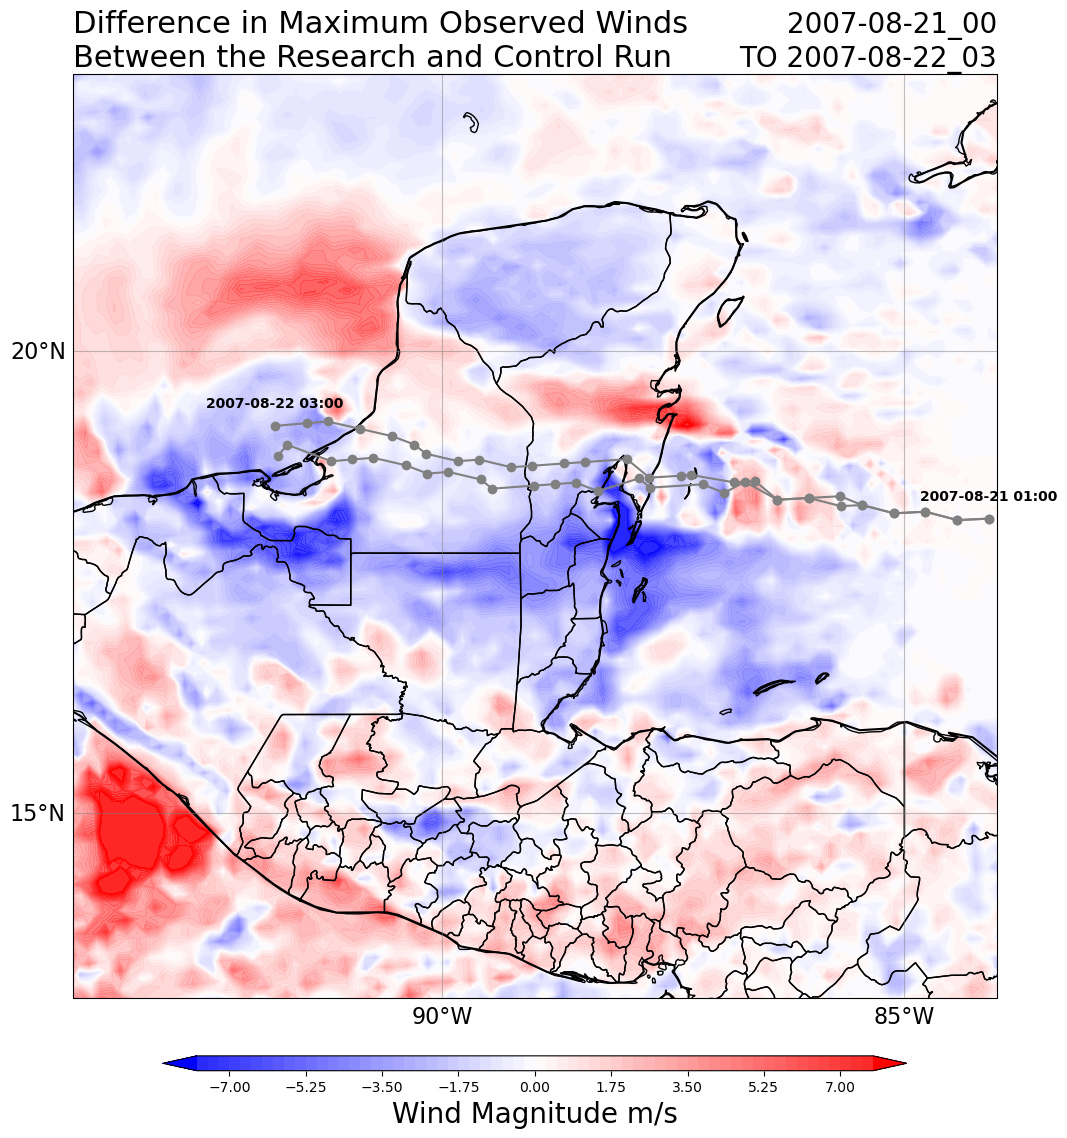

In [18]:
fig, ax = create_map_background()


plt.plot(lon_Dean_Adjusted, lat_Dean_Adjusted , "-o", color = 'grey')
plt.plot(lon_Dean_original, lat_Dean_original,"-o", color = 'grey')

for i in range(0,len(date_Dean_MYNN),len(date_Dean_MYNN)-1):
    plt.annotate(date_Dean_MYNN[i], (lon_Dean_Adjusted[i], lat_Dean_Adjusted[i]), ha = 'center',
                xytext = (lon_Dean_Adjusted[i], lat_Dean_Adjusted[i]+.2), weight = 'bold')

#We will look at the first WRF out file for plotting information
wrf_out_first_file = xr.open_dataset(Parent_wrfout_unadjusted_d01_n[0])  
lon = wrf_out_first_file['XLONG'][0,:,:].values                    #Array of longitudes
lat = wrf_out_first_file['XLAT'][0,:,:].values                     #Array of Latitudes

plot = plt.contourf(lon, lat, (max_winds1_3_a-max_winds1_3), origin = 'lower', levels = np.arange(-7.75,8.0,.25),
            cmap = 'bwr', alpha = .85, extend ='both')

cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .2, aspect = 50, extend = 'both')
cbar.ax.set_xlabel('Wind Magnitude m/s', fontsize = 20)

plt.title(f'2007-08-21_00\nTO 2007-08-22_03', loc = 'right', fontsize = 20)
plt.title(f'Difference in Maximum Observed Winds\nBetween the Research and Control Run', loc = 'left', fontsize = 22)